<a href="https://colab.research.google.com/github/elijahojelabi/Elijah.AISC2007/blob/main/Elijah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1

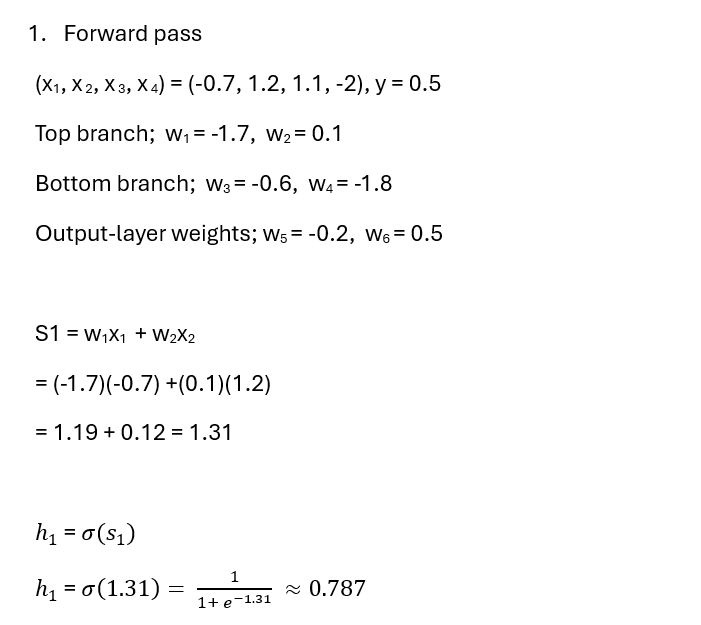

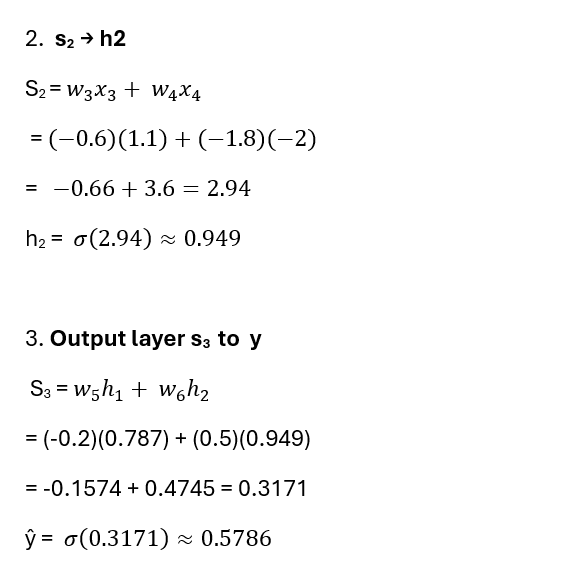

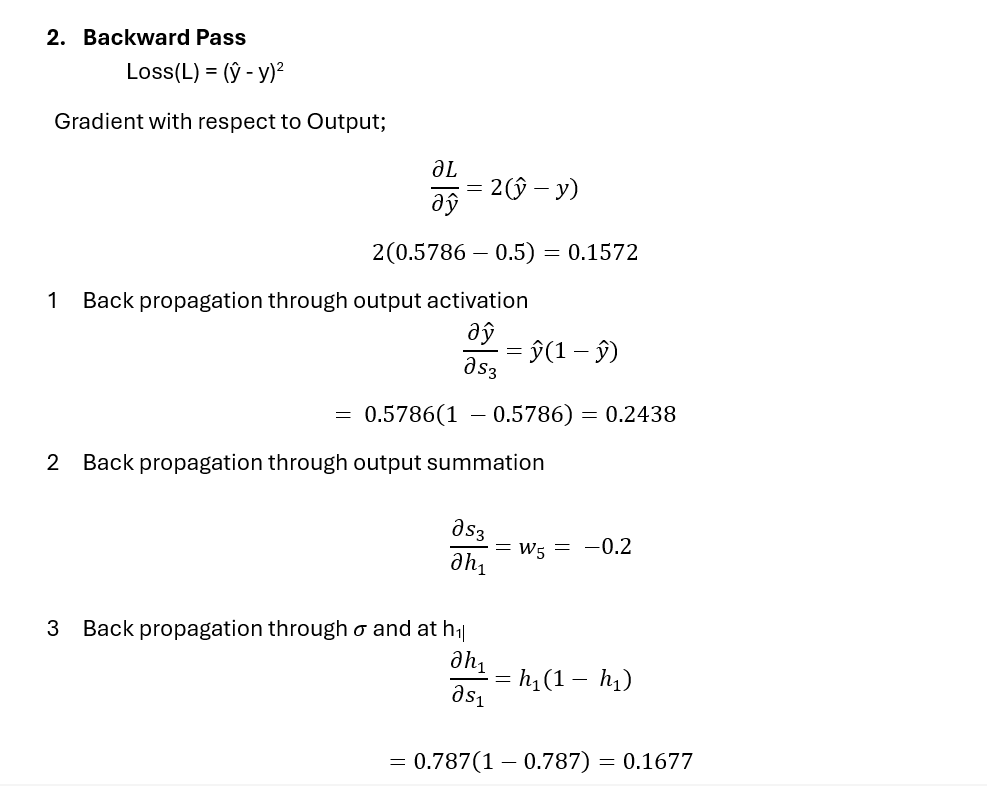

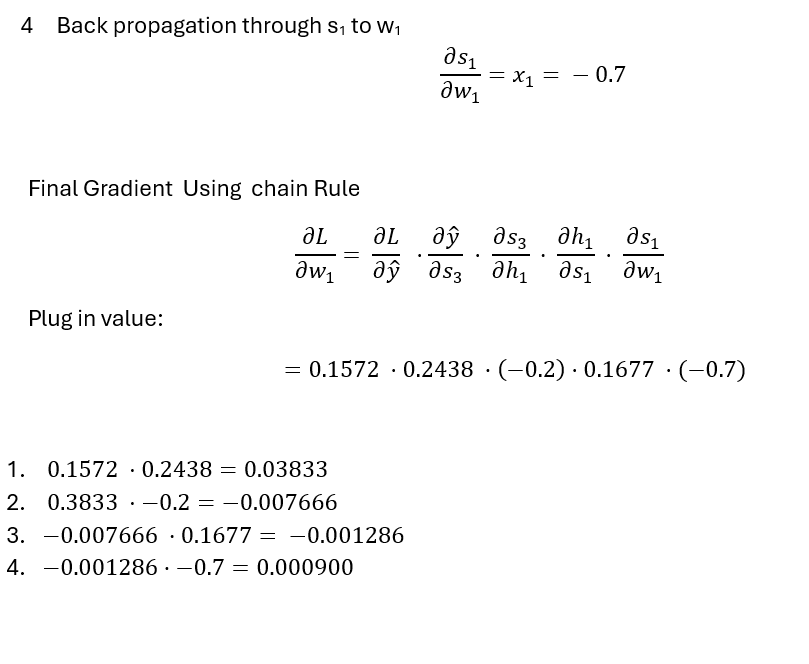

#2

2a

In [ ]:
import pandas as pd
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
for df in (train, test):
    if "date" in df.columns: df.drop(columns=["date"], inplace=True)
    unnamed = [c for c in df.columns if c.lower().startswith("unnamed")]
    if unnamed: df.drop(columns=unnamed, inplace=True)
n_train, n_test = train.shape[0], test.shape[0]
print("Training samples:", n_train)
print("Test samples:    ", n_test)

Training samples: 8143
Test samples:     9752


2b

Units  1 -> test accuracy: 0.7899
Units  5 -> test accuracy: 0.9159
Units 10 -> test accuracy: 0.9297
Units 20 -> test accuracy: 0.9393
Units 50 -> test accuracy: 0.8928


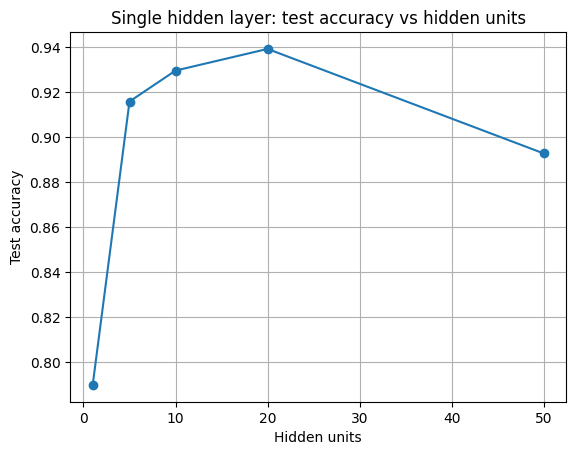

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

features = ["Temperature","Humidity","Light","CO2","HumidityRatio"]
X_train = train[features].values; y_train = train["Occupancy"].values.astype(int)
X_test  = test[features].values;  y_test  = test["Occupancy"].values.astype(int)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train); X_test_s = scaler.transform(X_test)

units_list = [1,5,10,20,50]
single_results = {}

for u in units_list:
    clf = MLPClassifier(hidden_layer_sizes=(u,), max_iter=200, random_state=42)
    clf.fit(X_train_s, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_s))
    single_results[u] = acc
    print(f"Units {u:2d} -> test accuracy: {acc:.4f}")

plt.figure(); plt.plot(list(single_results.keys()), list(single_results.values()), marker='o'); plt.grid(True)
single_plot_path = "Layer_accuracy.png"
plt.title("Single hidden layer: test accuracy vs hidden units")
plt.xlabel("Hidden units")
plt.ylabel("Test accuracy")
plt.savefig(single_plot_path, bbox_inches='tight')

plt.grid(True)
plt.show()

2c

5-5 -> test accuracy: 0.9340
10-5 -> test accuracy: 0.9201
20-10 -> test accuracy: 0.9139


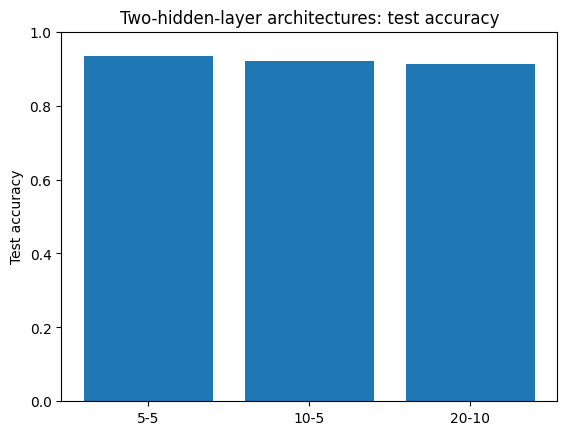

In [ ]:
architectures = {"5-5":[5,5], "10-5":[10,5], "20-10":[20,10]}
two_results = {}

for name, arch in architectures.items():
    clf = MLPClassifier(hidden_layer_sizes=tuple(arch), max_iter=200, random_state=42)
    clf.fit(X_train_s, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test_s))
    two_results[name] = acc
    print(f"{name} -> test accuracy: {acc:.4f}")

plt.figure(); plt.bar(list(two_results.keys()), list(two_results.values()))
two_plot_path = "accuracy.png"
plt.savefig(two_plot_path, bbox_inches='tight')
plt.title("Two-hidden-layer architectures: test accuracy")
plt.ylabel("Test accuracy")
plt.ylim(0,1)
plt.show()

2D

2(d) Discussion

Increasing single-layer hidden units improved test accuracy. Adding capacity helps the model fit more complex relationships between sensors and occupancy.

Two-layer architectures provided comparable or slightly improved accuracy depending on sizes.

Use a validation set or cross-validation and early stopping to avoid overfitting.

Standardize inputs and consider class imbalance if present.

#3

The authors used a Long Short-Term Memory (LSTM) neural network to forecast future stock opening prices for GOOGL and NKE, using historical data from Yahoo Finance. They split the data into 80% training and 20% testing, feeding the model sequences of past prices via sliding windows. The architecture featured four stacked LSTM layers with dropout to prevent overfitting. Training across multiple epochs (12 to 100) showed that more epochs improved accuracy. Predictions aligned well with actual trends, though stock volatility occasionally caused deviations.